# Анализ данных (EDA)

## Разделы:
1. **Работа с датасетом**: Очистка, предобработка и исследование данных.
2. **Визуализация**: Построение графиков и визуализация ключевых показателей.
3. **Тематическое моделирование (BERTopic)**

### Описание столбцов

| Название столбца    | Описание                                                                      |
|---------------------|-------------------------------------------------------------------------------|
| `local_id`          | Уникальный идентификатор услуги в эталонном прайсе                            |
| `type`              | Категория или тип услуги, например, лабораторные тесты                        |
| `gt_type_name`      | Подкатегория услуги, например, Биохимия                                       |
| `parent_id_name`    | Родительская категория услуги, например, Лабораторная диагностика             |
| `local_name`        | Эталонное название услуги                                                     |
| `lpu_name`          | Название клиники                                                              |
| `service_name`      | Название услуги в клинике                                                     |


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
from bertopic import BERTopic

In [2]:
data = pd.read_csv("data/data.csv")

In [3]:
data.sample(5)

,local_name,local_id,parent_id,type,gt_type_name,parent_id_name,site_active,service_name,lpu_name
11980,Кальций ионизированный,5598.0,64.0,laboratory_tests,Биохимия,Лабораторная диагностика,True,Кальций ионизированный,UNIКлиник
7674,Компьютерная томография сустава (лучезапястног...,14598.0,55.0,instrumental_tests,Компьютерная томография,Инструментальная диагностика,True,Компьютерная томография одной кисти и лучезапя...,"ООО ""Клинический госпиталь на Яузе"""
14170,CA 72-4,6046.0,64.0,laboratory_tests,Онкомаркеры,Лабораторная диагностика,True,Са-72.4,Вита-мед
11926,Альдостерон,6052.0,64.0,laboratory_tests,Биохимия,Лабораторная диагностика,True,Альдостерон,UNIКлиник
11249,Компьютерная томография головного мозга,14576.0,55.0,instrumental_tests,Компьютерная томография,Инструментальная диагностика,True,Компьютерная томография головного мозга,UNIКлиник


### Проверка пропусков

In [7]:
data.isna().sum()

local_name           0
local_id             0
parent_id         2824
type              2824
gt_type_name      2824
parent_id_name    2824
site_active       2824
service_name         0
lpu_name             0
dtype: int64

Одинаковое количество пропусков в столбцах `parent_id`, `type`, `gt_type_name`, `parent_id_name`, `site_active`, логично предположить, что эти пропуски в одних и тех же семплах

In [8]:
nan_dataset = data[data.isnull().any(axis=1)]

In [9]:
nan_dataset.head(5)

,local_name,local_id,parent_id,type,gt_type_name,parent_id_name,site_active,service_name,lpu_name
10,Комплексное обследование: обследование детей,15351.0,NaN,NaN,NaN,NaN,NaN,Первичное лабораторное обследование детей при ...,Инвитро
148,Оценка инсулинорезистентности (индекс HOMA-IR),7606.0,NaN,NaN,NaN,NaN,NaN,Оценка инсулинорезистентности: глюкоза (натоща...,Инвитро
161,Иммунологическое обследование первичное,6685.0,NaN,NaN,NaN,NaN,NaN,Иммунологическое обследование скрининговое,Инвитро
387,Аспирационная биопсия эндометрия (Пайпель-биоп...,8170.0,NaN,NaN,NaN,NaN,NaN,Исследование аспирата из полости матки (мазки),Инвитро
391,Комплексное гистологическое и иммуногистохимич...,7614.0,NaN,NaN,NaN,NaN,NaN,"HER2/neu экспрессия (HER2-статус, иммуногистох...",Инвитро


In [10]:
nan_dataset['local_name'].value_counts()

local_name
Прием (осмотр, консультация) врача-акушера-гинеколога в клинике    18
Прием (осмотр, консультация) врача-уролога в клинике               17
Прием (осмотр, консультация) врача-онколога в клинике              17
Прием (осмотр, консультация) врача-невролога в клинике             16
Прием (осмотр, консультация) врача-терапевта в клинике             15
                                                                   ..
Медосмотр предварительный п. 23, жен., 40+                          1
Медосмотр периодический п. 23, муж.                                 1
Медосмотр периодический п. 23, жен.                                 1
Медосмотр периодический п. 23, жен., 40+                            1
Протеиновый батончик c витаминами bioniq "Соленая Карамель"         1
Name: count, Length: 1371, dtype: int64

Очень много примеров начинается с слова `Прием`

In [11]:
nan_dataset[nan_dataset['local_name'].str.startswith('Прием')].head(5)

,local_name,local_id,parent_id,type,gt_type_name,parent_id_name,site_active,service_name,lpu_name
784,"Прием педиатром ребенка первичный, на дому в п...",59.0,NaN,NaN,NaN,NaN,NaN,Здоровый ребёнок: для детей от 0 до 14 лет,Инвитро
4692,"Прием (осмотр, консультация) врача-генетика в ...",18139.0,NaN,NaN,NaN,NaN,NaN,Причины стресса (с интерпретацией врача-генетика),Gemotest
5060,Прием врача первичный на дому в пределах терри...,51.0,NaN,NaN,NaN,NaN,NaN,Прием врача первичный на дому в пределах терри...,Budu СПб
5062,Прием врача повторный на дому в пределах терри...,54.0,NaN,NaN,NaN,NaN,NaN,Комплексный прием врача повторный на дому в пр...,Budu СПб
5063,Прием врача повторный на дому в пределах терри...,56.0,NaN,NaN,NaN,NaN,NaN,Прием врача повторный на дому в пределах терри...,Budu СПб


Все семплы которые начинаются `Прием` содержат в себе NaN

Посмотрим какие уникальные уникальные значения у столбца parent_id_name

In [12]:
data['parent_id_name'].value_counts()

parent_id_name
Лабораторная диагностика        18662
Инструментальная диагностика     2179
Справки                            19
Консультация специалиста            9
Чекап                               7
Name: count, dtype: int64

Консультация специалиста имеет 9 уникальных вариаций, стоит изучить подробнее и посмотреть на то, что хранят столбцы в которых есть пропуски

In [13]:
data.loc[data['parent_id_name'] == "Консультация специалиста", 'local_name'].tolist()

['Прием (осмотр, консультация) врача-педиатра на дому',
 'Прием (осмотр, консультация) врача-терапевта на дому',
 'Прием (осмотр, консультация) врача-педиатра на дому',
 'Прием (осмотр, консультация) врача-терапевта на дому',
 'Прием (осмотр, консультация) врача-педиатра на дому',
 'Прием (осмотр, консультация) врача-терапевта на дому',
 'Прием (осмотр, консультация) врача-педиатра на дому',
 'Прием (осмотр, консультация) врача-терапевта на дому',
 'Прием (осмотр, консультация) врача-педиатра на дому']

Все эти примеры для консультации с врачом `на дому`, стоит это учесть

In [14]:
dataset_startswith = nan_dataset[nan_dataset['local_name'].str.startswith('Прием')]

In [15]:
dataset_startswith.shape

(722, 9)

722 семпла с пропусками,к которые начинаются со слова `Прием`

In [16]:
data['gt_type_name'].unique()

array(['Комплекс', 'Общеклинические', 'Биохимия', 'Генетика', nan,
       'Инфекции', 'Другое', 'Аллергология', 'Витамины', 'Гормоны',
       'Онкомаркеры', 'Иммунологические', 'Рентгенология',
       'Риски по заболеваниям', 'Электрофизиологические методы',
       'Ультразвуковые методы', 'Функциональные методы', 'Эндоскопия',
       'Справки общие', 'Магнитно-резонансные методы',
       'Компьютерная томография', 'Консультация специалиста на дому',
       'Справки для взрослых', 'Справки для детей', 'Другие комплексы',
       'Проверка внутренних органов'], dtype=object)

1. Изучив эти данные, можно сказать, что есть 3 различные вариации консультаций с врачём (`на дому`, `в клинике`, `дистанционно`). 
2. Но после работы с этой гипотезой, необходимо проверить нет ли других вариантов

In [17]:
data['parent_id_name'].unique()

array(['Лабораторная диагностика', nan, 'Инструментальная диагностика',
       'Чекап', 'Справки', 'Консультация специалиста'], dtype=object)

Пропуски в столбце `parent_id_name`, если в `local_name` консультация с врачом, можно заполнить как `Консультация специалиста`

In [18]:
columns_with_nan = ['type', 'site_active', 'parent_id_name', 'gt_type_name']

In [19]:
for value in columns_with_nan:
    print(f"Уникальные значения для столбца {value} :{data[value].unique()}")
    print(50 * "-")

Уникальные значения для столбца type :['laboratory_tests' nan 'instrumental_tests' 'specialities'
 'manipulations']
--------------------------------------------------
Уникальные значения для столбца site_active :[True nan]
--------------------------------------------------
Уникальные значения для столбца parent_id_name :['Лабораторная диагностика' nan 'Инструментальная диагностика' 'Чекап'
 'Справки' 'Консультация специалиста']
--------------------------------------------------
Уникальные значения для столбца gt_type_name :['Комплекс' 'Общеклинические' 'Биохимия' 'Генетика' nan 'Инфекции'
 'Другое' 'Аллергология' 'Витамины' 'Гормоны' 'Онкомаркеры'
 'Иммунологические' 'Рентгенология' 'Риски по заболеваниям'
 'Электрофизиологические методы' 'Ультразвуковые методы'
 'Функциональные методы' 'Эндоскопия' 'Справки общие'
 'Магнитно-резонансные методы' 'Компьютерная томография'
 'Консультация специалиста на дому' 'Справки для взрослых'
 'Справки для детей' 'Другие комплексы' 'Проверка внутрен

**Исходя из всего вышесказанного** 
1. Необходимо добавить в столбец `gt_type_name` два новых класса `Консультация с специалистом дистанционно`, `Консультация с специалистом в клинике`
2. Пропуски в столбце type, необходимо заполнить для всех консультаций с врачом как `specialities`
3. Исходя из данных site_active во всех семплах имеет значение `True`, поэтому следует и заполнить пропуски этого столбца везде значениями `True`
4. Столбец `parent_id_name` необходимо заполнить как `Консультация специалиста`

In [20]:
patterns = {
    r'\bв клинике\b': 'Консультация специалиста в клинике',
    r'\bна дому\b': 'Консультация специалиста на дому',
    r'\bдистанционно\b': 'Консультация специалиста дистанционно'
}

In [21]:
def fill_col_consultation(data: pd.DataFrame, patterns: dict) -> pd.DataFrame:
    """
    Заполняет столбцы 'gt_type_name', 'parent_id_name', 'type' и 'parent_id' в DataFrame 
    на основе совпадений с шаблонами в столбце 'local_name'.

    Parameters_:
        - data (DataFrame): Датасет, содержащий текстовые данные в столбце 'local_name', которые нужно обработать.
        - patterns (dict): Словарь, где ключи — это регулярные выражения (шаблоны), а значения — значения для столбца 'gt_type_name', 
                           которые будут присвоены при совпадении с шаблоном.

    Returns_:
        - data (DataFrame): Обновленный DataFrame с заполненными столбцами 'gt_type_name', 'parent_id_name', 'type' и 'parent_id' 
                   для строк, соответствующих шаблонам.
    """
    for pattern, gt_type_value in patterns.items():
        mask = data['local_name'].str.contains(pattern, na=False, regex=True)
        data.loc[mask, 'gt_type_name'] = gt_type_value
        data.loc[mask, 'parent_id_name'] = 'Консультация специалиста'
        data.loc[mask, 'type'] = "specialities"
        data.loc[mask, 'parent_id'] = 50.0

    return data

In [22]:
data = fill_col_consultation(data, patterns)

In [23]:
data['site_active'].fillna(True, inplace=True)

In [24]:
data['gt_type_name'].unique()

array(['Комплекс', 'Общеклинические', 'Биохимия', 'Генетика', nan,
       'Инфекции', 'Другое', 'Аллергология', 'Витамины', 'Гормоны',
       'Онкомаркеры', 'Иммунологические',
       'Консультация специалиста на дому', 'Рентгенология',
       'Риски по заболеваниям', 'Консультация специалиста в клинике',
       'Консультация специалиста дистанционно',
       'Электрофизиологические методы', 'Ультразвуковые методы',
       'Функциональные методы', 'Эндоскопия', 'Справки общие',
       'Магнитно-резонансные методы', 'Компьютерная томография',
       'Справки для взрослых', 'Справки для детей', 'Другие комплексы',
       'Проверка внутренних органов'], dtype=object)

Добавили два новых класса `Консультация специалиста в клинике`, `Консультация специалиста дистанционно`

In [25]:
data.isna().sum()

local_name           0
local_id             0
parent_id         2069
type              2069
gt_type_name      2069
parent_id_name    2069
site_active          0
service_name         0
lpu_name             0
dtype: int64

У нас было 722 пропуска, которые начинались с слова `Прием`, но что-то не состыкуется, 2824-722=2102. Необходимо проверить, что лишнего я убрал

In [26]:
def search_pattern(data, column, pattern):
    filtered_data = data[data[column].apply(lambda x: bool(re.search(pattern, x)) if isinstance(x, str) else False)]
    return filtered_data

filtered_data = search_pattern(data=data, column='local_name', pattern=r'\bв клинике\b')

In [27]:
filtered_data['local_name'].unique()[20:30]

array(['Прием (осмотр, консультация) врача-психиатра-нарколога в клинике',
       'Прием (осмотр, консультация) врача-терапевта в клинике',
       'Осмотр (консультация) врача-физиотерапевта в клинике',
       'Прием (осмотр, консультация) врача-гастроэнтеролога в клинике',
       'Консультация психолога в клинике',
       'Прием (осмотр, консультация) врача-психотерапевта в клинике',
       'Прием (осмотр, консультация) врача сурдолога в клинике',
       'Прием (осмотр, консультация) врача-нейрохирурга в клинике',
       'Прием (осмотр, консультация) врача-маммолога в клинике',
       'Прием (осмотр, консультация) врача-пластического хирурга в клинике'],
      dtype=object)

1. У всех паттернов все семплы соответствуют, даже верно выделены те, которые не начинаются с слова `Приём`, например семпл `Осмотр (консультация) врача-физиотерапевта дистанционно`.
2. Все они подходят для верного заполнения пропусков

In [28]:
data['parent_id'].unique()

array([ 64.,  nan,  50.,  55.,  78., 141.])

In [29]:
data[data['parent_id'] == 141].head(5)

,local_name,local_id,parent_id,type,gt_type_name,parent_id_name,site_active,service_name,lpu_name
7384,"Справка для поступающего в ВУЗ, колледж или не...",19315.0,141.0,laboratory_tests,Справки общие,Справки,True,"Медкомиссия для студентов, выдача справки по ф...",Budu СПб
9393,"Справка для поступающего в ВУЗ, колледж или не...",19315.0,141.0,laboratory_tests,Справки общие,Справки,True,Обследование и оформление справки по форме 086/у,АВС-МЕДИЦИНА
9396,Справка для ГИБДД (ф. 003-В/У),19317.0,141.0,manipulations,Справки для взрослых,Справки,True,Медицинская комиссия с оформлением справки в Г...,АВС-МЕДИЦИНА
9429,Справка в школу или детский сад (ф. 026/у),19310.0,141.0,manipulations,Справки для детей,Справки,True,Обследование и оформление справки по форме 026/у,АВС-МЕДИЦИНА
9514,Справка в бассейн (ф. 083/4-89),19311.0,141.0,laboratory_tests,Справки общие,Справки,True,Осмотр врача-терапевта с оформлением справки в...,АВС-МЕДИЦИНА


1. parent_id_55 = type_instrumental_tests = Инструментальная диагностика
2. parent_id_64 = laboratory_tests = Лабораторная диагностика
3. parent_id_78 = laboratory_tests = чекап
4. parent_id_141 = laboratory_tests/manipulations = Справки
5. parent_id_50 = specialities = Консультация специалиста

Можно провести ещё более глубокий анализ и заполнить остальные пропуски эвристиками, довольно много было мной замечено логичных зависимостей, но было бы правильно, если бы мои гипотезы по заполнению пропусков были проверены специалистом. Поэтому для начала лучше выкатить MVP, а затем продолжить анализ данных для выявления новых паттернов

### Визуализация

In [30]:
data_for_plots = data
data_for_plots.dropna(inplace=True)

In [31]:
data_for_plots['type'].value_counts()

type
laboratory_tests      18679
instrumental_tests     2179
specialities            764
manipulations             9
Name: count, dtype: int64

In [32]:
descriptions = {
        'type': 'Типы услуги',
        'gt_type_name': 'Подкатегория услуги',
        'parent_id_name': 'Родительская категория услуги',
        'lpu_name': 'Название клиники'
        }

In [33]:
def plot_value_counts_with_labels(data: pd.DataFrame, 
    columns: list, 
    nrows: int = 2, 
    ncols: int = 2, 
    name_col: dict = None, 
    figsize=(14, 10)) -> None:
    """
    Функция для построения матрицы горизонтальных графиков распределения значений для нескольких столбцов
    с указанием числового значения рядом с каждым столбцом и добавлением описания из словаря.
    
    Parameters_:
        - data (DataFrame): Датасет.
        - columns (list): Список названий столбцов, для которых нужно построить графики.
        - nrows (int): Количество строк в матрице графиков.
        - ncols (int): Количество столбцов в матрице графиков.
        - figsize (tuple): Размер фигуры.
    Returns_:
        None
    """ 
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        value_counts = data[column].value_counts().sort_values(ascending=True)
        
        ax = value_counts.plot(kind='barh', ax=axes[i], title=column)
        
        for p in ax.patches:
            ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                        ha='left', va='center')
            
        title = f'{column}'
        if name_col and column in name_col:
            title += f" - {name_col[column]}"
        ax.set_title(title)
        
        ax.set_xlabel('Количество')
        ax.set_ylabel('Значение')

    plt.tight_layout()
    plt.show()

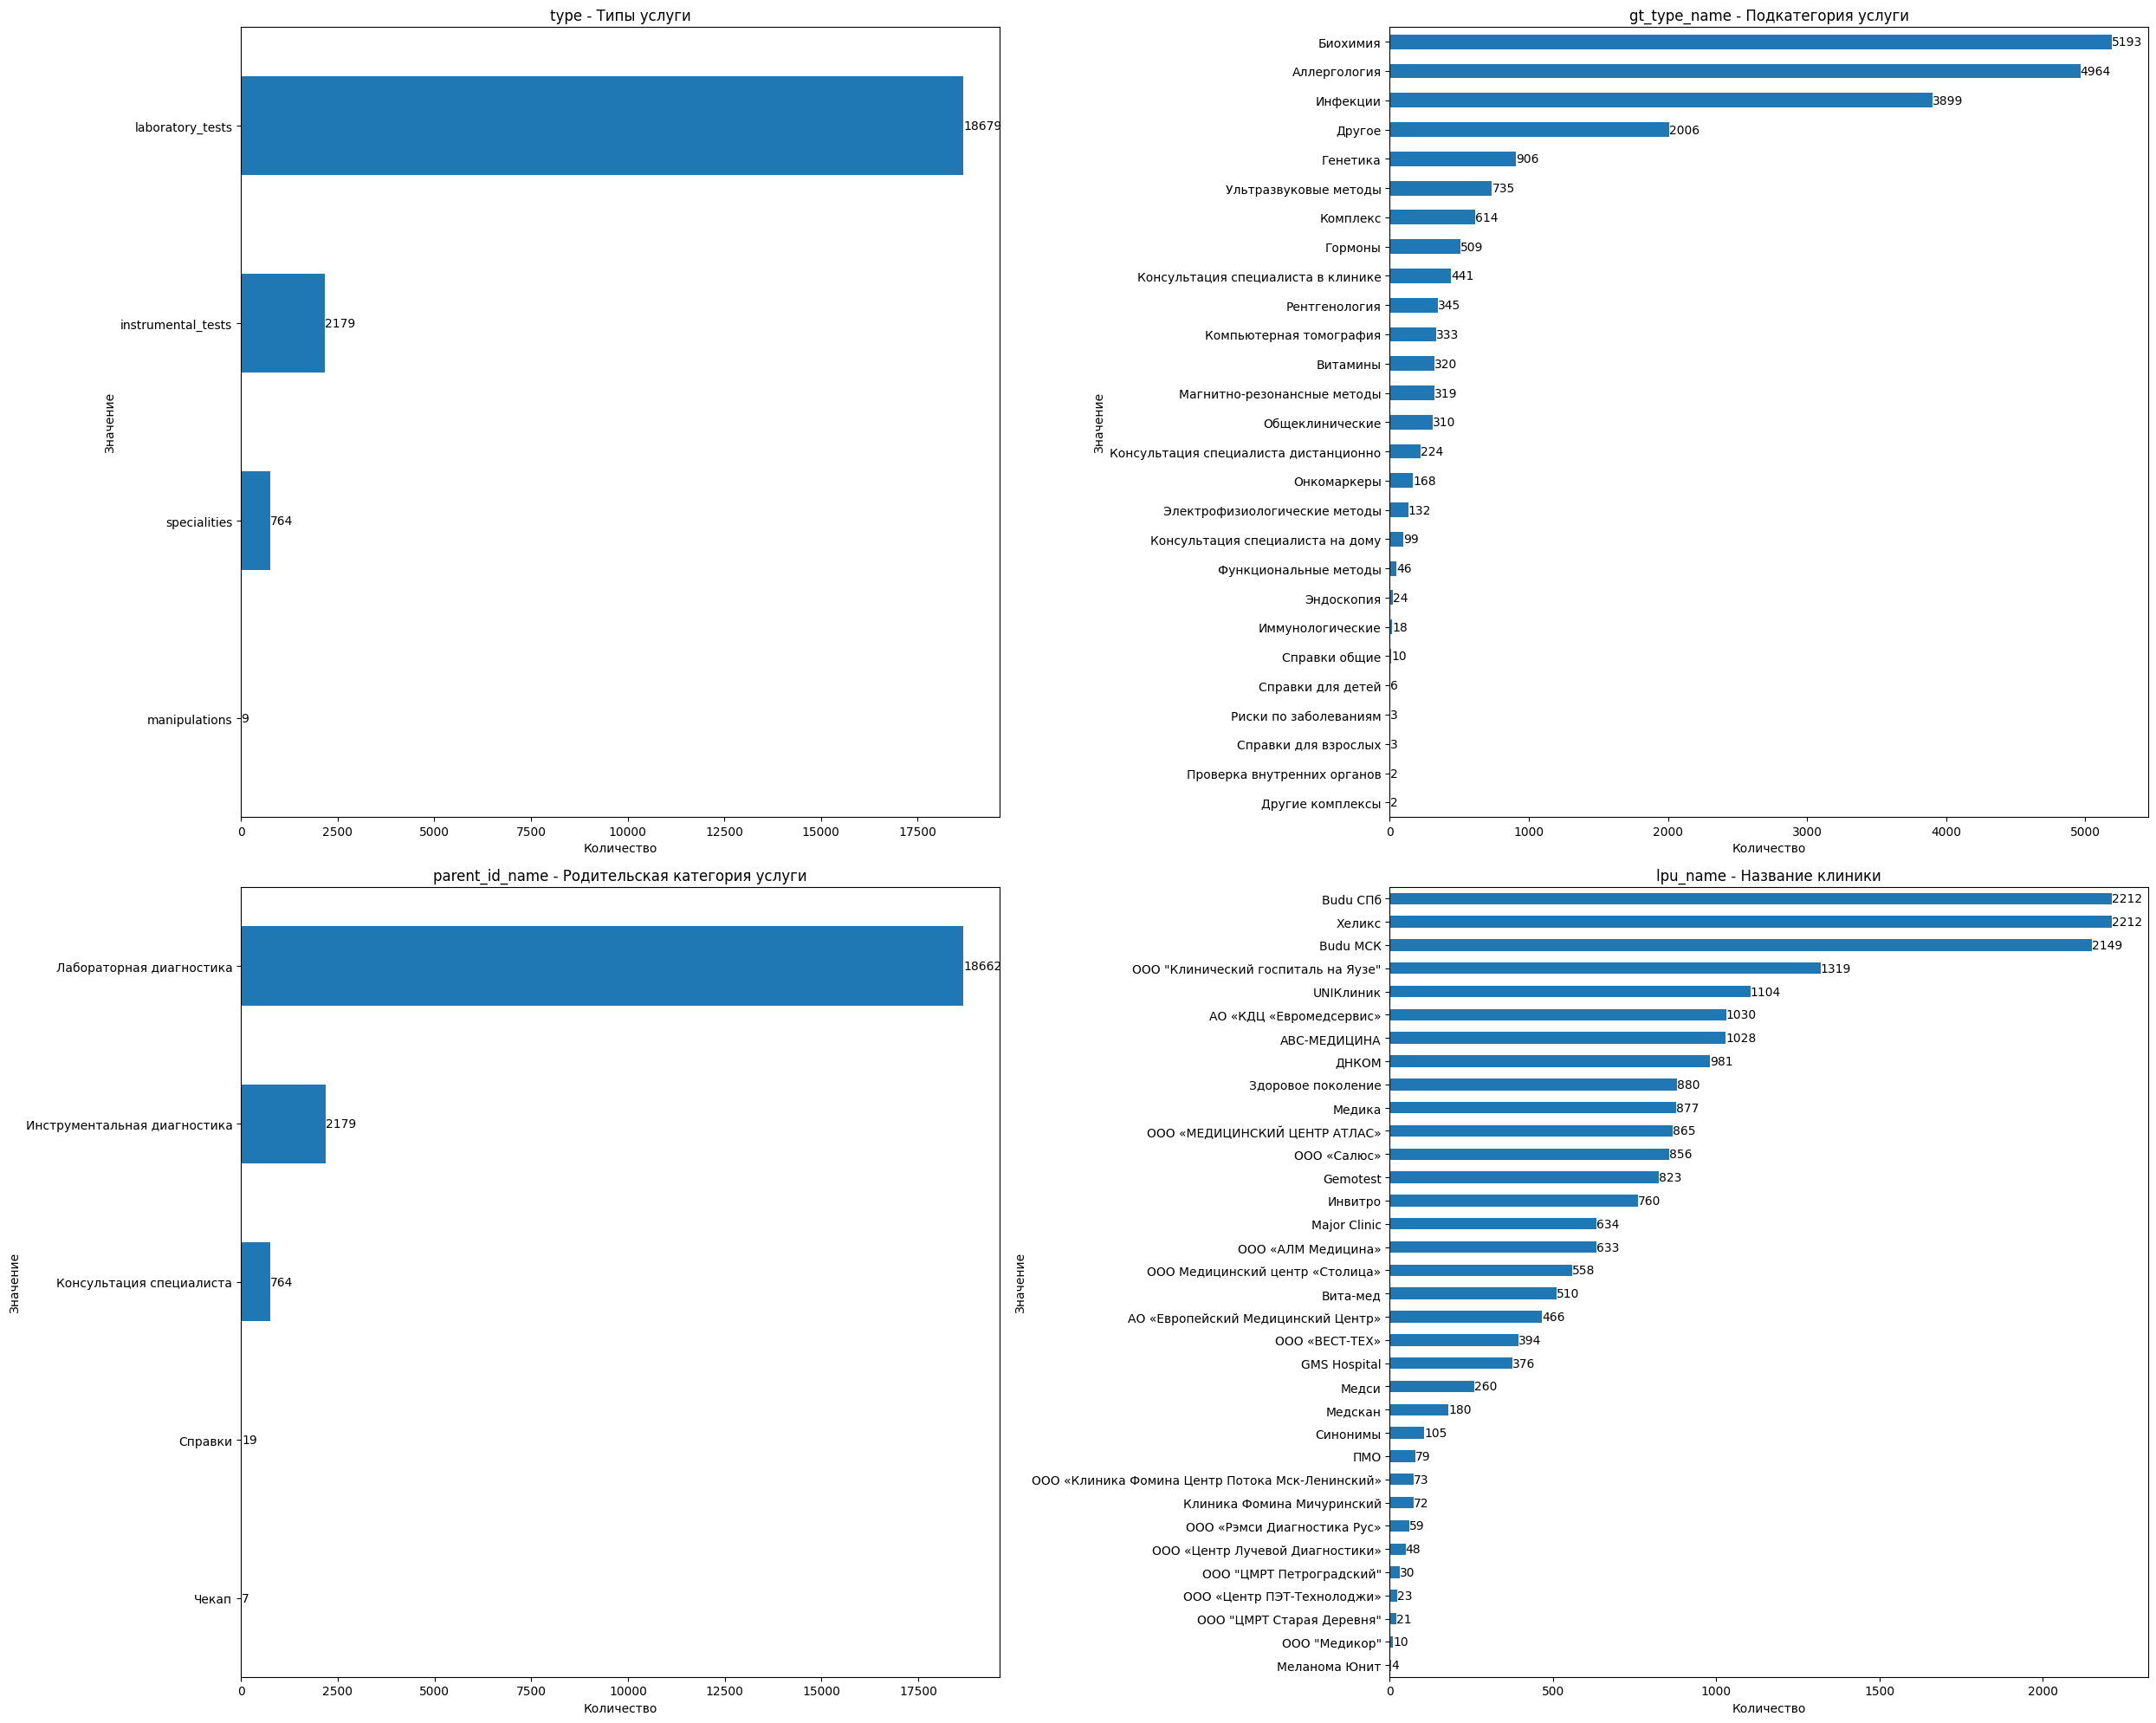

In [34]:
plot_value_counts_with_labels(data=data_for_plots, 
                         columns=["type", "gt_type_name", "parent_id_name", "lpu_name"], 
                         figsize=(25, 20),
                         ncols=2,
                         nrows=2,
                         name_col=descriptions)

Исходя из графиков, можно с уверенностью сказать, что большинство услуг связанно с анализами и проведением различных процедур

Для того, чтобы построить график на основе TF-IDF, необходимо применить лемматизацию, удалить лишние символы, привести все слова к нижнему регистру

In [35]:
nlp = spacy.load('ru_core_news_md')

def preprocess_text(text: str) -> str:
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    doc = nlp(text.lower())
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])


data_for_plots['lemmatized_text'] = data_for_plots['local_name'].apply(preprocess_text)

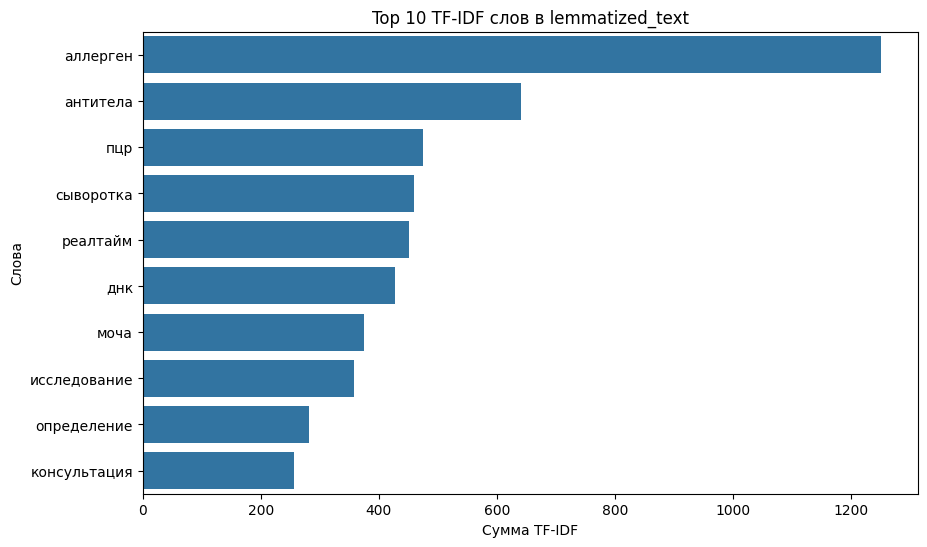

In [36]:
def plot_tfidf_bar_chart(data: pd.DataFrame, column_name: str, top_k:int = 10) -> list:
    """
    Вычисляет TF-IDF для указанного столбца DataFrame и строит график.

    Parameters_:
        - data (pd.DataFrame): Датасет
        - column_name (str): Название столбца датасета
        - top_k (int): количество top_k слов

    Returns_
        - top_words.index.tolist() (str): список самых частовстречающихся строк
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data[column_name])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    tfidf_sum = tfidf_df.sum(axis=0).sort_values(ascending=False)

    top_words = tfidf_sum.head(top_k)

    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_words.index, x=top_words.values)
    plt.title(f'Top {top_k} TF-IDF слов в {column_name}')
    plt.ylabel('Слова')
    plt.xlabel('Сумма TF-IDF')
    plt.show()

    return top_words.index.tolist()

top_k = plot_tfidf_bar_chart(data=data_for_plots, column_name='lemmatized_text', top_k=10)

Самое значимое слово по мнению TF-IDF `аллерген`, другие слова довольно сильно отстают от него

In [37]:
def plot_wordcloud(data: pd.DataFrame, 
    text_column: str, 
    width:int = 800, 
    height:int = 400, 
    background_color='white'):
    """
    Создает и отображает облако слов для заданного столбца текстовых данных.

    Parameters_:
        - data (pd.DataFrame): DataFrame с данными, содержащий текстовую информацию.
        - text_column (str): Название столбца, содержащего текстовые данные, которые будут использованы для генерации облака слов.
        - width (int, optional): Ширина облака слов. Значение по умолчанию — 800.
        - height (int, optional): Высота облака слов. Значение по умолчанию — 400.
        - background_color (str, optional): Цвет фона облака слов. Значение по умолчанию — 'white'.
        
    Returns_:
        None: Функция отображает облако слов и не возвращает никаких значений.
    """
    text = ' '.join(data[text_column].tolist())
    
    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') 
    plt.show()

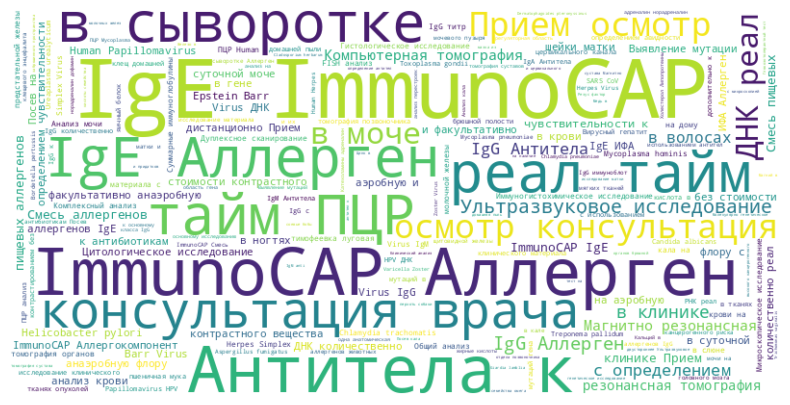

In [38]:
plot_wordcloud(data=data_for_plots, text_column='local_name')

Этот график (Словесное облако) позволяет определить наиболее часто встречающиеся слова, такие как `Антитела`, `Аллерген` - что подтверждает теорию `TF-IDF`

In [39]:
data_for_plots['type'].unique()

array(['laboratory_tests', 'specialities', 'instrumental_tests',
       'manipulations'], dtype=object)

In [40]:
def plot_heatmap(data: pd.DataFrame, 
    clinic_column: str, 
    type_column: str, 
    figsize=(10, 6), 
    cmap='Blues', 
    annot=False):
    """
    Строит тепловую карту категорий медицинских услуг по клиникам.

    Parameters_:
        - data (pd.DataFrame): DataFrame с данными, содержащий информацию о клиниках и типах услуг.
        - clinic_column (str): Название столбца с названием клиник.
        - type_column (str): Название столбца с типом услуг.
        - figsize (tuple, optional): Размер графика в формате (ширина, высота). Значение по умолчанию — (10, 6).
        - cmap (str, optional): Цветовая схема для тепловой карты. Значение по умолчанию — 'Blues'.
        - annot (bool, optional): Определяет, отображать ли числовые значения на тепловой карте. По умолчанию False.

    Returns_:
        None: Функция выводит тепловую карту и не возвращает значений.
    """
    category_counts = pd.crosstab(data[clinic_column], data[type_column])
    
    plt.figure(figsize=figsize)
    sns.heatmap(category_counts, cmap=cmap, annot=annot)
    plt.title('Тепловая карта категорий медицинских услуг по клиникам')
    plt.xlabel('Тип услуг')
    plt.ylabel('Клиники')
    plt.show()

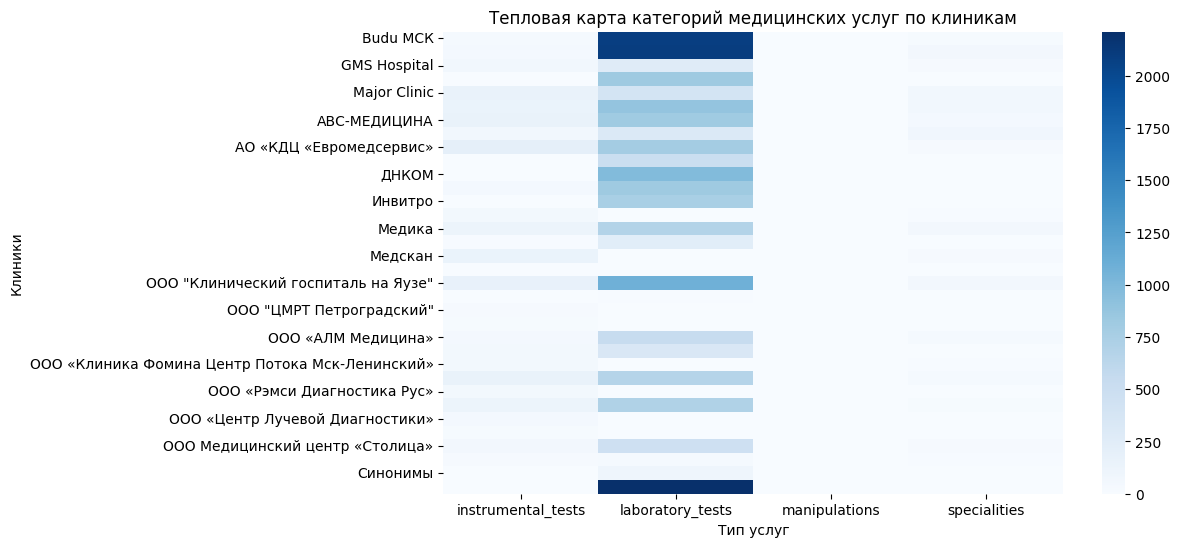

In [41]:
plot_heatmap(data=data_for_plots, 
             clinic_column='lpu_name', 
             type_column='type', 
             figsize=(10, 6), 
             cmap='Blues', 
             annot=False)

Все компании больше всего специализирируются на `laboratory_tests` (лабораторная диагностика), медицинская компания `Budu МСК` предоставляет больше всех услугу по лабораторным тестам

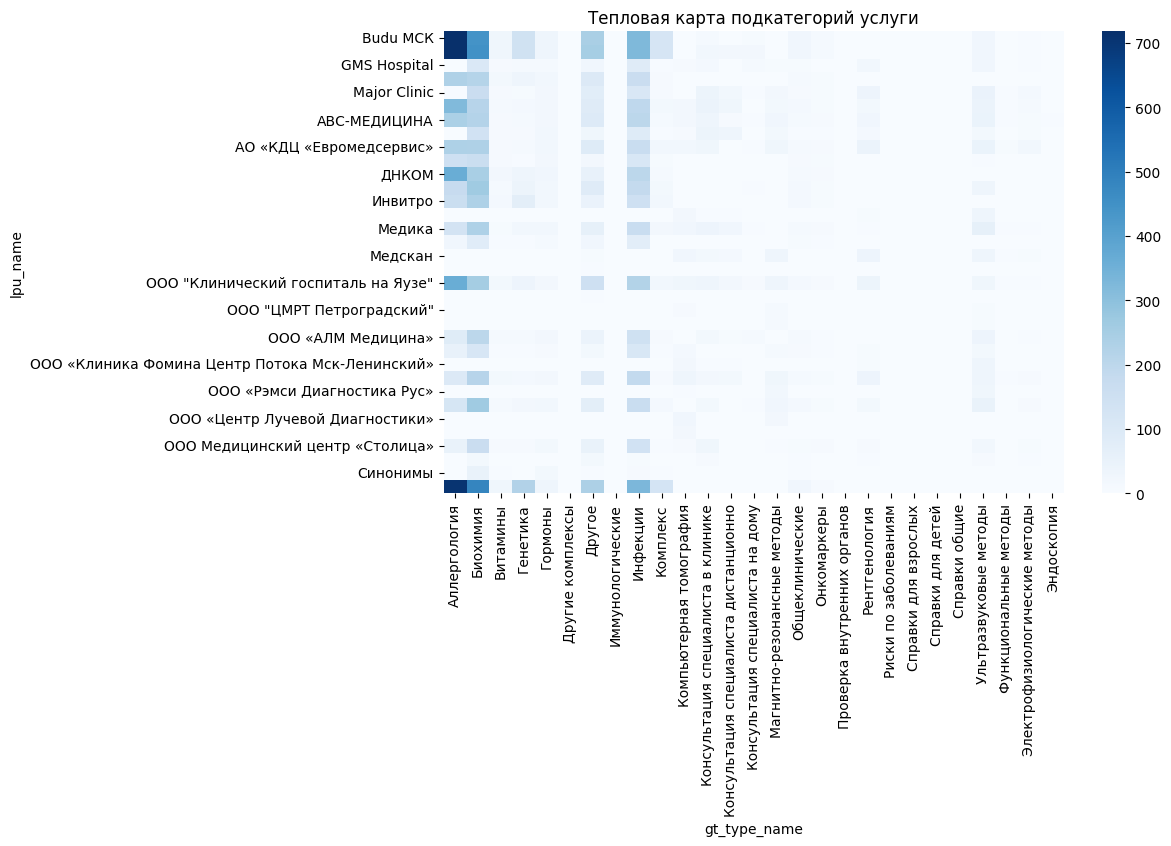

In [42]:
category_counts = pd.crosstab(data_for_plots['lpu_name'], data_for_plots['gt_type_name'])
plt.figure(figsize=(10, 6))
sns.heatmap(category_counts, cmap='Blues', annot=False)
plt.title('Тепловая карта подкатегорий услуги')
plt.show()

Довольно большое количество компаний предоставляет услугу `Аллергология`, но существует многожество других услуг, которые практически не предоставляют или же нет спроса

### BERTopic

Для того, чтобы правильно воспользоваться BERTopic, необходимо правильно выбрать `эммбедер`, для этого воспользуюсь [репозиторием](`https://github.com/avidale/encodechka`) и выберу эмбедер подходящий для нашей задачи. Нам подходит `STS - Semantic text similarity`. Лучшая `STS` модель `deepvk/USER-bge-m3`

In [43]:
# sts_model = SentenceTransformer("deepvk/USER-bge-m3")
# topic_model = BERTopic(embedding_model=sts_model)
# topics, proba = topic_model.fit_transform(data_for_plots['local_name'])

In [44]:
# fig_visualize_barchart = topic_model.visualize_barchart(top_n_topics=10)
# fig_visualize_barchart.write_html("visualize_barchart.html")

In [45]:
# fig_visualize_topics = topic_model.visualize_topics(top_n_topics=10)
# fig_visualize_topics.write_html("fig_visualize_topics.html")

In [46]:
# fig_visualize_heatmap = topic_model.visualize_heatmap(top_n_topics=10)
# fig_visualize_heatmap.write_html("fig_visualize_heatmap.html")

Графики находятся в папке `plots` в html-формате